In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.utils.data as data

from torchvision import transforms, datasets
from sklearn.metrics import classification_report

from tqdm.auto import tqdm


In [2]:
EPOCHS = 1 # default = 10
BATCH_SIZE = 16
LEARNING_RATE = 0.0001
CLASS_NUM = 4

In [3]:
# 데이터 경로
dataset_path = "datasets/project_datas/"

# 직접 정제 + duplication code 사용한 데이터
# TRAIN_DATA_PATH = "hand_processing_data/train/"
# VALID_DATA_PATH = "hand_processing_data/valid/"
# TEST_DATA_PATH = "hand_processing_data/test/"

# duplication code만 적용한 데이터, 이 방법으로 train함
TRAIN_DATA_PATH = dataset_path + "train/"
VALID_DATA_PATH = dataset_path + "valid/"
TEST_DATA_PATH = dataset_path + "test/"


# Normalize용 mean 및 std
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

# 학습용 transform
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])

# 학습용 transform (데이터 개수 늘리는 증강 적용할 때 사용)
aug_transform1 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomVerticalFlip(p=1),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])
aug_transform2 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])

# 크기, Norm 만 적용 (for valid, test)
initial_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])


# data load
# # 증강 방법 1 = 원본 이미지에 상하(p=0.5), 좌우(p=0.5), 밝기(0.2)적용 = 2793장
train_data = datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=train_transform)
# # 증강 방법 2 = 원본 이미지 + 상하반전(밝기0.2) + 좌우반전(밝기0.2) = 2793 * 3 = 8379장
# 증강 방법 2를 사용해서 학습 진행했음
# train_data = datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=initial_transform)
# train_data += datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=aug_transform1)
# train_data += datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=aug_transform2)    

valid_data = datasets.ImageFolder(root=VALID_DATA_PATH, transform=initial_transform)
test_data = datasets.ImageFolder(root=TEST_DATA_PATH, transform=initial_transform)

train_data_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_data_loader = data.DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)
test_data_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

tensor([1, 1, 3, 1, 3, 1, 3, 0, 3, 0, 1, 2, 3, 2, 3, 0])
torch.Size([16, 3, 256, 256])

증강 적용 + norm 제거 이미지


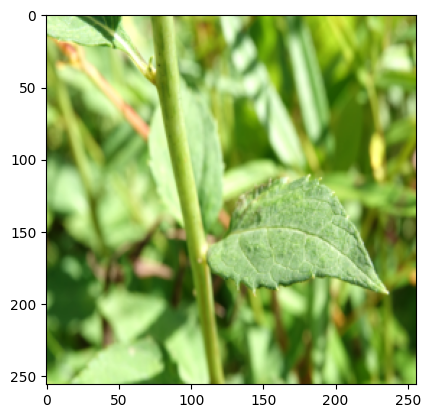

증강 적용 + norm 적용 이미지


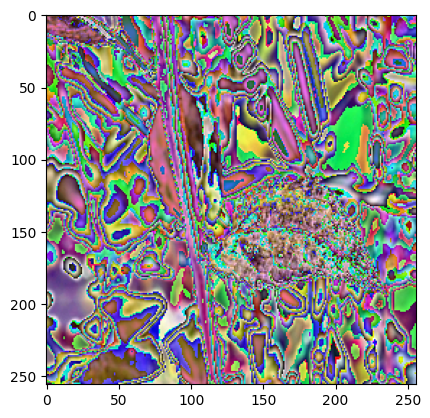

In [4]:
# data_loader의 이미지 및 shape, label 확인
topilimage = transforms.ToPILImage()
for img, label in train_data_loader:
    print(label)
    print(img.shape)
    remove_norm_img = topilimage(img[0]*torch.tensor(norm_std)[:, None, None] + torch.tensor(norm_mean)[:, None, None])
    normed_img = topilimage(img[0])
    
    print("\n증강 적용 + norm 제거 이미지")
    plt.imshow(remove_norm_img)
    plt.show()
    
    print("증강 적용 + norm 적용 이미지")
    plt.imshow(normed_img)
    plt.show()
    break

In [5]:
# 불러온 data class 순서 확인
print(valid_data.class_to_idx)
class_dict = valid_data.class_to_idx
# 꽃개오동 참취 곰취 개오동

# train, valid, test 개수 확인
print(len(train_data))
print(len(valid_data))
print(len(test_data))

{'Rhcrodhehd': 0, 'ckacnl': 1, 'rhacnl': 2, 'rodhehd': 3}
2793
446
698


In [6]:
# train device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# model load
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)

# class 분류용 FC layer 추가
cf_fc1 = nn.Linear(1000, 512)
cf_fc2 = nn.Linear(512, CLASS_NUM)
model.add_module('CF_fc1', cf_fc1)
model.add_module('CF_fc2', cf_fc2)

# gpu 여러개일 때 DataParallel 사용, train 및 valid 부분도 수정해줘야함
# model = torch.nn.DataParallel(model).to(device) 

# Single GPU
model = model.to(device)

# optim 및 loss_func 설정        
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_function = torch.nn.CrossEntropyLoss()

cuda


Using cache found in C:\Users\kser/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\kser\Anaconda3\envs\sgmse\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\kser\Anaconda3\envs\sgmse\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# model 파라미터 및 구조 확인
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(model))

print(model)

26071596
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), st

In [8]:
# 학습 결과 저장 폴더 이름 및 경로 지정
save_path = 'train_result/save/dupl_aug_5/'

if os.path.isdir(save_path) == True:
    print("!! 저장할 폴더와 동일한 이름의 폴더가 이미 존재합니다.")
else:
    print(f"{save_path} 경로에 저장 폴더가 생성되었습니다. ")
    os.makedirs(save_path)

train_result/save/dupl_aug_5/ 경로에 저장 폴더가 생성되었습니다. 


In [9]:
def train(model, trainloader, optimizer, loss_function, epoch, log_inter):
    model.train()
    # print(model)
    for batch_idx, (image, label) in enumerate(trainloader):
        image = image.to(device)
        label = label.to(device)
        # Forward pass
        output = model(image)
        # output = model.module.CF_fc(output) # DP사용할 때
        output = model.CF_fc1(output)
        output = model.CF_fc2(output)
        loss = loss_function(output, label)

        # Backward and optimize
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()

        # Printing the result at the specific interval
        if batch_idx % log_inter == 0: # log_inter = 100
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx, len(trainloader), 100. * batch_idx / len(trainloader),
                loss.item()))
            with open(save_path + 'result.txt', 'a') as f:
                f.write("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}\n".format(
                epoch, batch_idx, len(trainloader), 100. * batch_idx / len(trainloader),
                loss.item()))
                
def valid(model, validloader, batch_size, loss_function):
    model.eval()
    valid_loss = 0
    correct = 0

    with torch.no_grad():
        # 각 class별 f1-score 및 acc 계산용 array 저장
        all_pre = np.array([])
        all_lab = np.array([])
        
        for i, (image, label) in enumerate(tqdm(validloader)):
            image = image.to(device)
            label = label.to(device)
            output = model(image)
            # 분류를 위한 FC layer 추가
            output = model.CF_fc1(output)
            output = model.CF_fc2(output)
            # output = model.module.CF_fc(output) # DP사용할 때
            
            valid_loss += loss_function(output, label).item()    
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
                
            # 각 클래스별 f1-score 및 accuracy 계산을 위한 결과 저장
            tmp = prediction.squeeze(-1).cpu().numpy()
            tmp2 = label.cpu().numpy()
                
            # 모든 class의 f1-score 계산
            if all_pre.size == 0:
                all_pre = tmp
            else:
                all_pre = np.concatenate((all_pre, tmp))
            if all_lab.size == 0:
                all_lab = tmp2
            else:
                all_lab = np.concatenate((all_lab, tmp2))
    
    valid_loss /= (len(validloader.dataset) / batch_size)
    valid_accuracy = 100. * correct / len(validloader.dataset)
    return valid_loss, valid_accuracy, all_pre, all_lab

In [10]:
# model 저장용 valid_loss 설정
best_valid_loss = 100

# 전체 학습 진행
for epoch in range(0, EPOCHS):
    # train 학습 진행
    train(model, train_data_loader, optimizer, loss_function, epoch, log_inter = 2)
    
    # validation data에 대해서 평가
    valid_loss, valid_accuracy, all_pre, all_lab = valid(model, valid_data_loader, BATCH_SIZE, loss_function)
    
    # 각 클래스별 f1 score 계산 및 출력
    f1_scores = classification_report(all_lab, all_pre, digits=4)
    print(f1_scores)
    
    # 각 클래스별 accuracy 계산 및 출력
    class_acc = []
    for j in range(4):
        class_acc = (len(np.where((all_pre != j) & (all_lab != j))[0]) + \
            len(np.where((all_pre == j) & (all_lab == j))[0])) / len(all_lab)
        print("Class {0} accuracy : {1}".format(j, (len(np.where((all_pre != j) & (all_lab != j))[0]) + \
            len(np.where((all_pre == j) & (all_lab == j))[0])) / len(all_lab)))

    # val_loss 기준으로 best 모델을 저장
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_model = f'epoch_{epoch}_val_{round(valid_loss, 2)}.pt'
        torch.save(model, save_path+best_model)

    # epoch마다 학습 결과를 파일로 저장    
    with open(save_path + 'result.txt', 'a') as f:
        f.write(f"\n[EPOCH: {epoch}/{EPOCHS}],\
            \nValid Loss: {valid_loss}, \
            \nValid Accuracy: {valid_accuracy}% \
            \n\nf1-score: {f1_scores} \
            \nclass_dict: {class_dict},\nclass_acc: {class_acc}\n\n")

Train Epoch: 0 [0/175 (0%)]	Train Loss: 1.553104
Train Epoch: 0 [2/175 (1%)]	Train Loss: 1.090468


c:\Users\kser\Anaconda3\envs\sgmse\lib\site-packages\PIL\Image.py:2896: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Train Epoch: 0 [4/175 (2%)]	Train Loss: 0.327405
Train Epoch: 0 [6/175 (3%)]	Train Loss: 0.452915
Train Epoch: 0 [8/175 (5%)]	Train Loss: 0.558818
Train Epoch: 0 [10/175 (6%)]	Train Loss: 0.387001
Train Epoch: 0 [12/175 (7%)]	Train Loss: 0.110644
Train Epoch: 0 [14/175 (8%)]	Train Loss: 0.904153
Train Epoch: 0 [16/175 (9%)]	Train Loss: 0.258359
Train Epoch: 0 [18/175 (10%)]	Train Loss: 0.132052
Train Epoch: 0 [20/175 (11%)]	Train Loss: 0.039423
Train Epoch: 0 [22/175 (13%)]	Train Loss: 0.509752
Train Epoch: 0 [24/175 (14%)]	Train Loss: 0.446164
Train Epoch: 0 [26/175 (15%)]	Train Loss: 0.299841
Train Epoch: 0 [28/175 (16%)]	Train Loss: 1.004316
Train Epoch: 0 [30/175 (17%)]	Train Loss: 0.181916
Train Epoch: 0 [32/175 (18%)]	Train Loss: 0.082412
Train Epoch: 0 [34/175 (19%)]	Train Loss: 0.509088
Train Epoch: 0 [36/175 (21%)]	Train Loss: 0.908876
Train Epoch: 0 [38/175 (22%)]	Train Loss: 0.516723
Train Epoch: 0 [40/175 (23%)]	Train Loss: 0.440323
Train Epoch: 0 [42/175 (24%)]	Train Loss:

100%|██████████| 28/28 [01:25<00:00,  3.05s/it]


              precision    recall  f1-score   support

           0     0.9048    0.3551    0.5101       107
           1     0.9143    0.9143    0.9143       140
           2     0.9583    0.9829    0.9705       117
           3     0.5694    1.0000    0.7257        82

    accuracy                         0.8139       446
   macro avg     0.8367    0.8131    0.7801       446
weighted avg     0.8602    0.8139    0.7974       446

Class 0 accuracy : 0.8363228699551569
Class 1 accuracy : 0.9461883408071748
Class 2 accuracy : 0.984304932735426
Class 3 accuracy : 0.8609865470852018


In [11]:
# 학습된 model 불러오기
print(save_path+best_model)
model = torch.load(save_path+best_model) ## 학습 진행 후 바로 best_model load
print(model)

train_result/save/dupl_aug_5/epoch_0_val_0.83.pt
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0)

In [12]:
# test dataset에 대한 평가 진행
test_loss, test_accuracy, all_pre, all_lab = valid(model, test_data_loader, BATCH_SIZE, loss_function)

print()
print(class_dict)
print()
for j in range(4):
    print("Class {0} accuracy : {1}".format(j, (len(np.where((all_pre != j) & (all_lab != j))[0]) + \
        len(np.where((all_pre == j) & (all_lab == j))[0])) / len(all_lab)))

print()
print("\nf1-scores...\n")
print(classification_report(all_lab, all_pre, digits=4))

  0%|          | 0/44 [00:00<?, ?it/s]c:\Users\kser\Anaconda3\envs\sgmse\lib\site-packages\PIL\Image.py:2896: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 44/44 [02:39<00:00,  3.63s/it]

Class 0 accuracy : 0.9670487106017192
Class 1 accuracy : 0.9914040114613181
Class 2 accuracy : 0.9914040114613181
Class 3 accuracy : 0.9641833810888252
{'Rhcrodhehd': 0, 'ckacnl': 1, 'rhacnl': 2, 'rodhehd': 3}
              precision    recall  f1-score   support

           0     0.9769    0.8639    0.9170       147
           1     0.9831    0.9915    0.9872       234
           2     0.9939    0.9701    0.9818       167
           3     0.8698    0.9800    0.9216       150

    accuracy                         0.9570       698
   macro avg     0.9559    0.9514    0.9519       698
weighted avg     0.9600    0.9570    0.9570       698

